## Import the model and weights


In [91]:
from modeling.titok import *
from omegaconf import OmegaConf 
config = OmegaConf.load("configs/training/stage1/titok_l32_CSL.yaml")
model = TiTok(config)
weights = "titok_l_32_stage1_run1/checkpoint-Titok/pytorch_model.bin"

# load the weights 
model.load_state_dict(torch.load(weights))

<All keys matched successfully>

### Checking validation images

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S004159_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S004159_P0000_T00\000114.jpg
orginal image: torch.Size([3, 256, 256])


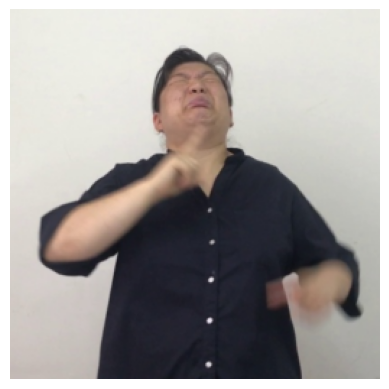

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


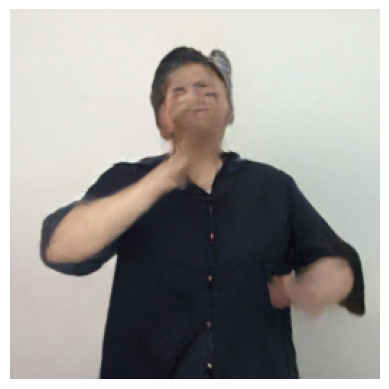

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S002899_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S002899_P0000_T00\000005.jpg
orginal image: torch.Size([3, 256, 256])


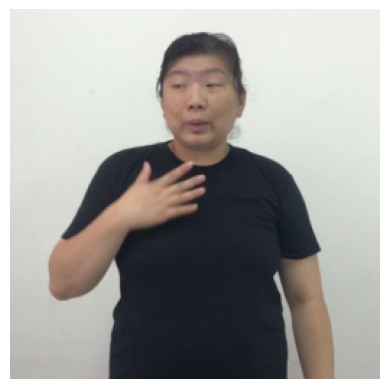

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


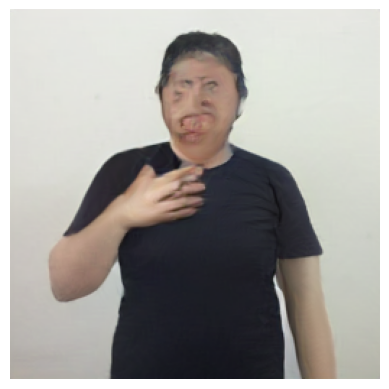

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S005680_P0006_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S005680_P0006_T00\000085.jpg
orginal image: torch.Size([3, 256, 256])


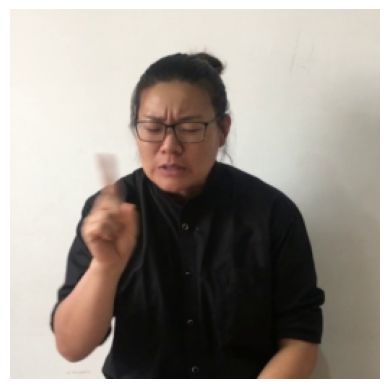

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


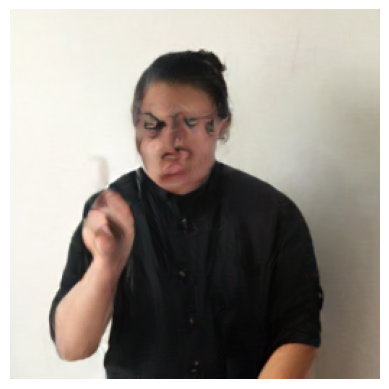

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S004159_P0002_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S004159_P0002_T00\000086.jpg
orginal image: torch.Size([3, 256, 256])


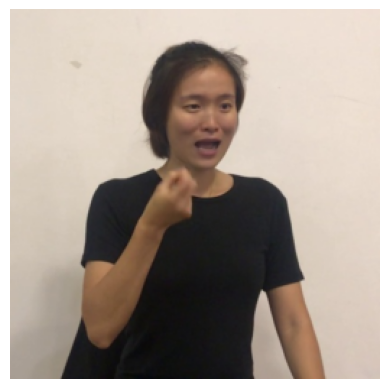

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


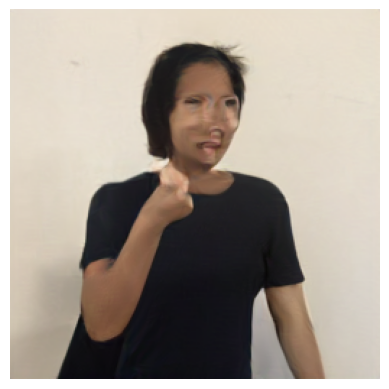

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S005354_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S005354_P0000_T00\000000.jpg
orginal image: torch.Size([3, 256, 256])


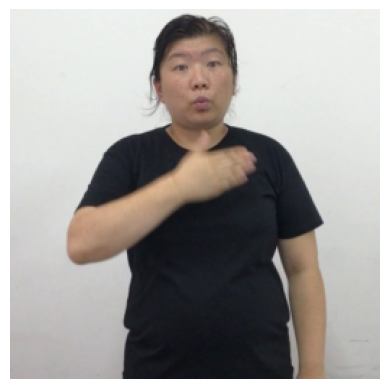

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


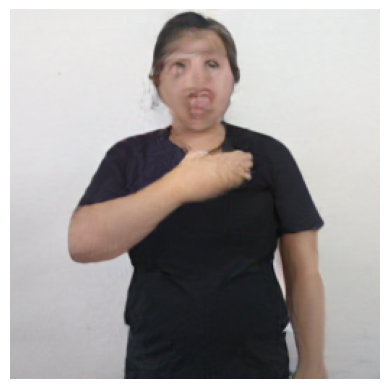

In [98]:
import os
import random
from PIL import Image
import numpy as np 
from torchvision import transforms
from IPython.display import display 
import matplotlib.pyplot as plt


maskgit =  PretrainedTokenizer(config.model.vq_model.pretrained_tokenizer_weight).to("cuda")
def tokenize_and_reconstruct(model, img_path=None, encoded_tokens=None):
    # Preprocess the image  
    image = Image.open(img_path).convert("RGB")
    person_size = 410
    # Calculate the center horizontal crop and lower vertical crop
    x_start = int((image.size[0] - person_size) // 2)  # Center horizontally
    x_end = x_start + person_size
    y_start = image.size[1] - person_size # Crop the lower vertical section
    y_end = image.size[1]

    # Crop the image (keeping center horizontal and lower vertical)
    image = image.crop((x_start, y_start, x_end, y_end))

    # add transforms 
    # Normalization values for ImageNet
    norm_mean = [0,0,0]
    norm_std = [1,1,1]
    # Data transformations for validation and test sets (no augmentation)
    eval_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to fixed size
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(norm_mean, norm_std)  # Normalize using ImageNet statistics
    ])

    image = eval_transform(image)
    print(f"orginal image: {image.shape}")
    # Plot the image
    plt.imshow(image.transpose(0, 1).transpose(1, 2))
    plt.axis('off')  # Remove axis
    plt.show()
    model = model.to("cuda")

    image = torch.from_numpy(np.array(image).astype(np.float32)).unsqueeze(0)
    if analyse_tensor== False: 
        encoded_tokens = model.encode(image.to("cuda"))[1]["min_encoding_indices"]
    print(f"encoded tokens: {encoded_tokens.shape}")
    reconstructed_image = model.decode_tokens(encoded_tokens)
    reconstructed_image = maskgit.decode(reconstructed_image.argmax(1))
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).to("cpu", dtype=torch.uint8).numpy()[0].transpose(1, 2, 0)
    #reconstructed_image = Image.fromarray(reconstructed_image.transpose(1, 2, 0))
    #print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    
    print(f"reconstructed image: {reconstructed_image.shape}")
    # Plot the image
    plt.imshow(reconstructed_image  )
    plt.axis('off')  # Remove axis
    plt.show()

img_path = config.dataset.params.img_path + "/dev"
# Get a list of all folders in the image path
folders = [os.path.join(img_path, folder) for folder in os.listdir(img_path) if os.path.isdir(os.path.join(img_path, folder))]

for i in range(5): 
    # Select a random folder
    random_folder = random.choice(folders)
    print(f"random folder: {random_folder}")
    # Get a list of all images in the selected folder
    analyse_tensor = False
    if analyse_tensor : 
        encoded_tokens = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.endswith(('.pt'))]
        random_token = random.choice(encoded_tokens)
        print(f"random token file: {random_token}")
        random_token = torch.load(random_token).unsqueeze(0).unsqueeze(0).cuda()
        print(f"encoded tokens: {random_token}")
    else: 
        images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]
    # Select a random image
    random_image_path = random.choice(images)
    print(f"random image: {random_image_path}")




    # Get the reconstuction + Display the reconstructed image
    tokenize_and_reconstruct(model=model, img_path=random_image_path, encoded_tokens=random_token)